# 모델 학습

In [1]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense

## 하이퍼파라미터

In [2]:
EPOCHS = 1000
RESULT_SAVE_PATH = 'results/'

## Inception-based 모델 정의

In [3]:
def Model():
    def inception(filters):
        def subnetwork(x):
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

## Data 전처리 함수 정의

In [4]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

## Data Augmentation 함수 정의

In [5]:
def augmentation(img, label):
    def flip(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        return x
    
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                   lambda: tfa.image.rotate(x,
                                       tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                       interpolation='BILINEAR'),
                   lambda: x)
        return x
    
    def translation(x):
        dx = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        dy = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.transform(x,
                                                [0, 0, dx, 0, 0, dy, 0, 0],
                                                interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    img = flip(img)
    img = rotate(img)
    img = translation(img)
           
    return img, label

## TFRecords 불러오기

In [6]:
tffiles = glob.glob('tfrecords/*')
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

## 데이터셋 나누기

In [7]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_size = int(ds_size * 0.7)

ds = dataset.shuffle(ds_size)
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

## 모델 생성

In [8]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 모델 학습하기

In [9]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000


W1116 22:33:18.069704 140587648227136 deprecation.py:323] From /home/jeyong/.conda/envs/tf2.0b1/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


55/55 [==============================] - 34s 621ms/step - loss: 0.7014 - accuracy: 0.5323 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/1000
55/55 [==============================] - 29s 524ms/step - loss: 0.6665 - accuracy: 0.5668 - val_loss: 0.6768 - val_accuracy: 0.5484
Epoch 3/1000
55/55 [==============================] - 32s 575ms/step - loss: 0.6846 - accuracy: 0.5242 - val_loss: 0.6750 - val_accuracy: 0.6586
Epoch 4/1000
55/55 [==============================] - 31s 556ms/step - loss: 0.6885 - accuracy: 0.5265 - val_loss: 0.6684 - val_accuracy: 0.5094
Epoch 5/1000
55/55 [==============================] - 30s 545ms/step - loss: 0.6820 - accuracy: 0.5276 - val_loss: 0.6345 - val_accuracy: 0.6613
Epoch 6/1000
55/55 [==============================] - 35s 632ms/step - loss: 0.6949 - accuracy: 0.5046 - val_loss: 0.6924 - val_accuracy: 0.5376
Epoch 7/1000
55/55 [==============================] - 30s 554ms/step - loss: 0.6896 - accuracy: 0.5098 - val_loss: 0.6852 - val_accurac

55/55 [==============================] - 32s 586ms/step - loss: 0.6250 - accuracy: 0.6152 - val_loss: 0.5506 - val_accuracy: 0.7245
Epoch 58/1000
55/55 [==============================] - 32s 579ms/step - loss: 0.6457 - accuracy: 0.5876 - val_loss: 0.5488 - val_accuracy: 0.7231
Epoch 59/1000
55/55 [==============================] - 29s 534ms/step - loss: 0.5975 - accuracy: 0.6538 - val_loss: 0.5344 - val_accuracy: 0.7285
Epoch 60/1000
55/55 [==============================] - 32s 578ms/step - loss: 0.6318 - accuracy: 0.5927 - val_loss: 0.5515 - val_accuracy: 0.7191
Epoch 61/1000
55/55 [==============================] - 29s 524ms/step - loss: 0.6345 - accuracy: 0.6060 - val_loss: 0.5596 - val_accuracy: 0.7392
Epoch 62/1000
55/55 [==============================] - 32s 586ms/step - loss: 0.6215 - accuracy: 0.6158 - val_loss: 0.5361 - val_accuracy: 0.7325
Epoch 63/1000
55/55 [==============================] - 32s 584ms/step - loss: 0.6508 - accuracy: 0.5812 - val_loss: 0.5339 - val_accuracy:

55/55 [==============================] - 29s 524ms/step - loss: 0.5176 - accuracy: 0.6734 - val_loss: 0.5003 - val_accuracy: 0.7325
Epoch 114/1000
55/55 [==============================] - 28s 515ms/step - loss: 0.5363 - accuracy: 0.6480 - val_loss: 0.4203 - val_accuracy: 0.7608
Epoch 115/1000
55/55 [==============================] - 30s 547ms/step - loss: 0.5680 - accuracy: 0.6319 - val_loss: 0.5615 - val_accuracy: 0.7003
Epoch 116/1000
55/55 [==============================] - 31s 568ms/step - loss: 0.5821 - accuracy: 0.6313 - val_loss: 0.4297 - val_accuracy: 0.7688
Epoch 117/1000
55/55 [==============================] - 29s 531ms/step - loss: 0.5395 - accuracy: 0.6584 - val_loss: 0.4314 - val_accuracy: 0.7809
Epoch 118/1000
55/55 [==============================] - 27s 482ms/step - loss: 0.5316 - accuracy: 0.6538 - val_loss: 0.4776 - val_accuracy: 0.7608
Epoch 119/1000
55/55 [==============================] - 31s 567ms/step - loss: 0.5453 - accuracy: 0.6492 - val_loss: 0.4185 - val_acc

Epoch 169/1000
55/55 [==============================] - 31s 562ms/step - loss: 0.5221 - accuracy: 0.6596 - val_loss: 0.3694 - val_accuracy: 0.8306
Epoch 170/1000
55/55 [==============================] - 33s 598ms/step - loss: 0.5385 - accuracy: 0.6526 - val_loss: 0.3656 - val_accuracy: 0.8280
Epoch 171/1000
55/55 [==============================] - 30s 550ms/step - loss: 0.5318 - accuracy: 0.6480 - val_loss: 0.3601 - val_accuracy: 0.8212
Epoch 172/1000
55/55 [==============================] - 30s 544ms/step - loss: 0.4962 - accuracy: 0.6861 - val_loss: 0.3808 - val_accuracy: 0.7997
Epoch 173/1000
55/55 [==============================] - 33s 593ms/step - loss: 0.5065 - accuracy: 0.6912 - val_loss: 0.3804 - val_accuracy: 0.8172
Epoch 174/1000
55/55 [==============================] - 30s 554ms/step - loss: 0.5370 - accuracy: 0.6532 - val_loss: 0.3832 - val_accuracy: 0.8159
Epoch 175/1000
55/55 [==============================] - 32s 577ms/step - loss: 0.5134 - accuracy: 0.6642 - val_loss: 0

Epoch 225/1000
55/55 [==============================] - 30s 551ms/step - loss: 0.4229 - accuracy: 0.7189 - val_loss: 0.1739 - val_accuracy: 0.9207
Epoch 226/1000
55/55 [==============================] - 28s 507ms/step - loss: 0.4475 - accuracy: 0.7154 - val_loss: 0.1656 - val_accuracy: 0.9409
Epoch 227/1000
55/55 [==============================] - 30s 554ms/step - loss: 0.4378 - accuracy: 0.7091 - val_loss: 0.1690 - val_accuracy: 0.9462
Epoch 228/1000
55/55 [==============================] - 32s 586ms/step - loss: 0.4663 - accuracy: 0.6959 - val_loss: 0.1595 - val_accuracy: 0.9422
Epoch 229/1000
55/55 [==============================] - 31s 565ms/step - loss: 0.4723 - accuracy: 0.7068 - val_loss: 0.2047 - val_accuracy: 0.9180
Epoch 230/1000
55/55 [==============================] - 28s 501ms/step - loss: 0.4278 - accuracy: 0.7316 - val_loss: 0.1455 - val_accuracy: 0.9489
Epoch 231/1000
55/55 [==============================] - 32s 582ms/step - loss: 0.4352 - accuracy: 0.7068 - val_loss: 0

Epoch 281/1000
55/55 [==============================] - 32s 582ms/step - loss: 0.3822 - accuracy: 0.7471 - val_loss: 0.2414 - val_accuracy: 0.9382
Epoch 282/1000
55/55 [==============================] - 30s 547ms/step - loss: 0.4385 - accuracy: 0.7108 - val_loss: 0.0967 - val_accuracy: 0.9677
Epoch 283/1000
55/55 [==============================] - 29s 528ms/step - loss: 0.4182 - accuracy: 0.7235 - val_loss: 0.0937 - val_accuracy: 0.9610
Epoch 284/1000
55/55 [==============================] - 32s 574ms/step - loss: 0.4089 - accuracy: 0.7327 - val_loss: 0.0843 - val_accuracy: 0.9704
Epoch 285/1000
55/55 [==============================] - 30s 549ms/step - loss: 0.3725 - accuracy: 0.7454 - val_loss: 0.0944 - val_accuracy: 0.9624
Epoch 286/1000
55/55 [==============================] - 30s 550ms/step - loss: 0.4062 - accuracy: 0.7327 - val_loss: 0.0878 - val_accuracy: 0.9637
Epoch 287/1000
55/55 [==============================] - 31s 572ms/step - loss: 0.4003 - accuracy: 0.7131 - val_loss: 0

Epoch 337/1000
55/55 [==============================] - 27s 492ms/step - loss: 0.3908 - accuracy: 0.7408 - val_loss: 0.1066 - val_accuracy: 0.9610
Epoch 338/1000
55/55 [==============================] - 32s 588ms/step - loss: 0.4320 - accuracy: 0.7039 - val_loss: 0.0877 - val_accuracy: 0.9664
Epoch 339/1000
55/55 [==============================] - 33s 602ms/step - loss: 0.4132 - accuracy: 0.7062 - val_loss: 0.0877 - val_accuracy: 0.9812
Epoch 340/1000
55/55 [==============================] - 28s 506ms/step - loss: 0.3463 - accuracy: 0.7742 - val_loss: 0.0790 - val_accuracy: 0.9758
Epoch 341/1000
55/55 [==============================] - 31s 563ms/step - loss: 0.3704 - accuracy: 0.7535 - val_loss: 0.1323 - val_accuracy: 0.9597
Epoch 342/1000
55/55 [==============================] - 30s 539ms/step - loss: 0.4264 - accuracy: 0.7229 - val_loss: 0.1081 - val_accuracy: 0.9637
Epoch 343/1000
55/55 [==============================] - 31s 572ms/step - loss: 0.4287 - accuracy: 0.7039 - val_loss: 0

## 학습 결과 Plot

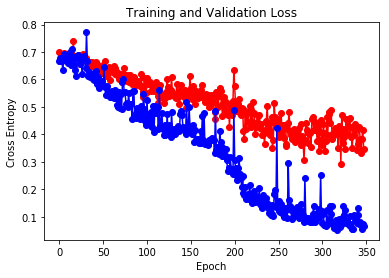

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

## 모델 저장

In [11]:
model.save('model/inception_model.h5')